# NB 03: Robust ICA Module Decomposition

Decompose each organism's fitness matrix into stable independent
components (modules) using the robust ICA pipeline.

Algorithm (adapted from Borchert et al. 2019):
1. Standardize: center each gene row to mean 0, scale by std
2. Determine n_components via PCA (Marchenko-Pastur threshold)
3. Run FastICA 30-50× with different random seeds
4. Cluster all components by |cosine similarity| (DBSCAN)
5. Stable clusters = modules; compute gene weights (Pearson r)
6. Threshold membership: |weight| >= 0.3, max 50 genes per module

**Run locally** — no Spark needed.

In [1]:
import pandas as pd
import numpy as np
import json
import sys
from pathlib import Path

# Add src to path for pipeline import
sys.path.insert(0, str(Path('../src').resolve()))
from ica_pipeline import (
    standardize_matrix, select_n_components, robust_ica,
    compute_gene_weights, threshold_membership
)

DATA_DIR = Path('../data')
MATRIX_DIR = DATA_DIR / 'matrices'
MODULE_DIR = DATA_DIR / 'modules'
MODULE_DIR.mkdir(parents=True, exist_ok=True)

# Ensure dependencies
try:
    from sklearn.decomposition import FastICA
    print("scikit-learn available")
except ImportError:
    import subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', 'scikit-learn'])
    print("Installed scikit-learn")

scikit-learn available


In [2]:
# Load pilot organisms
pilots = pd.read_csv(DATA_DIR / 'pilot_organisms.csv')
pilot_ids = pilots['orgId'].tolist()
print(f"Pilot organisms: {pilot_ids}")

# Load matrix summary
summary = pd.read_csv(MATRIX_DIR / 'matrix_summary.csv')
summary

Pilot organisms: ['DvH', 'Btheta', 'Methanococcus_S2', 'psRCH2', 'Putida', 'Phaeo', 'Marino', 'pseudo3_N2E3', 'Koxy', 'Cola', 'WCS417', 'Caulo', 'SB2B', 'pseudo6_N2E2', 'Dino', 'pseudo5_N2C3_1', 'Miya', 'Pedo557', 'MR1', 'Keio', 'Korea', 'PV4', 'pseudo1_N1B4', 'acidovorax_3H11', 'SynE', 'Methanococcus_JJ', 'BFirm', 'Kang', 'ANA3', 'Cup4G11', 'pseudo13_GW456_L13', 'Ponti']


,orgId,n_genes,n_experiments,matrix_density,mean_fitness,std_fitness
0,DvH,2741,757,1.000000,-0.099084,0.576292
1,Btheta,4055,519,0.999753,-0.097398,0.566827
2,Methanococcus_S2,1244,371,1.000000,-0.431622,1.179508
3,psRCH2,3349,350,0.999701,-0.082268,0.628115
4,Putida,4778,300,1.000000,-0.076308,0.549560
5,Phaeo,3099,274,0.999355,-0.090818,0.552037
6,Marino,3650,255,0.999452,-0.037380,0.458180
7,pseudo3_N2E3,5028,211,1.000000,-0.076518,0.483575
8,Koxy,4608,208,1.000000,-0.105429,0.718381
9,Cola,3954,202,1.000000,-0.067037,0.508444


## 1. PCA Dimensionality Selection

DvH: matrix (2741, 757), selected 114 components


Btheta: matrix (4055, 519), selected 100 components


Methanococcus_S2: matrix (1244, 371), selected 94 components


psRCH2: matrix (3349, 350), selected 86 components


Putida: matrix (4778, 300), selected 85 components


Phaeo: matrix (3099, 274), selected 70 components


Marino: matrix (3650, 255), selected 70 components


pseudo3_N2E3: matrix (5028, 211), selected 67 components


Koxy: matrix (4608, 208), selected 63 components


Cola: matrix (3954, 202), selected 53 components


WCS417: matrix (4419, 201), selected 60 components


Caulo: matrix (3312, 198), selected 62 components


SB2B: matrix (3121, 190), selected 68 components
pseudo6_N2E2: matrix (5133, 188), selected 58 components


Dino: matrix (3187, 186), selected 58 components


pseudo5_N2C3_1: matrix (5193, 184), selected 56 components


Miya: matrix (2531, 178), selected 58 components


Pedo557: matrix (4423, 177), selected 57 components


MR1: matrix (3782, 176), selected 60 components
Keio: matrix (3789, 168), selected 50 components


Korea: matrix (3393, 162), selected 47 components


PV4: matrix (3009, 160), selected 54 components


pseudo1_N1B4: matrix (4336, 147), selected 42 components
acidovorax_3H11: matrix (3935, 140), selected 48 components


SynE: matrix (1899, 129), selected 41 components


Methanococcus_JJ: matrix (1383, 129), selected 32 components
BFirm: matrix (5428, 113), selected 41 components


Kang: matrix (2003, 108), selected 40 components


ANA3: matrix (3668, 107), selected 39 components
Cup4G11: matrix (6384, 106), selected 34 components


pseudo13_GW456_L13: matrix (4350, 106), selected 42 components
Ponti: matrix (3685, 104), selected 33 components


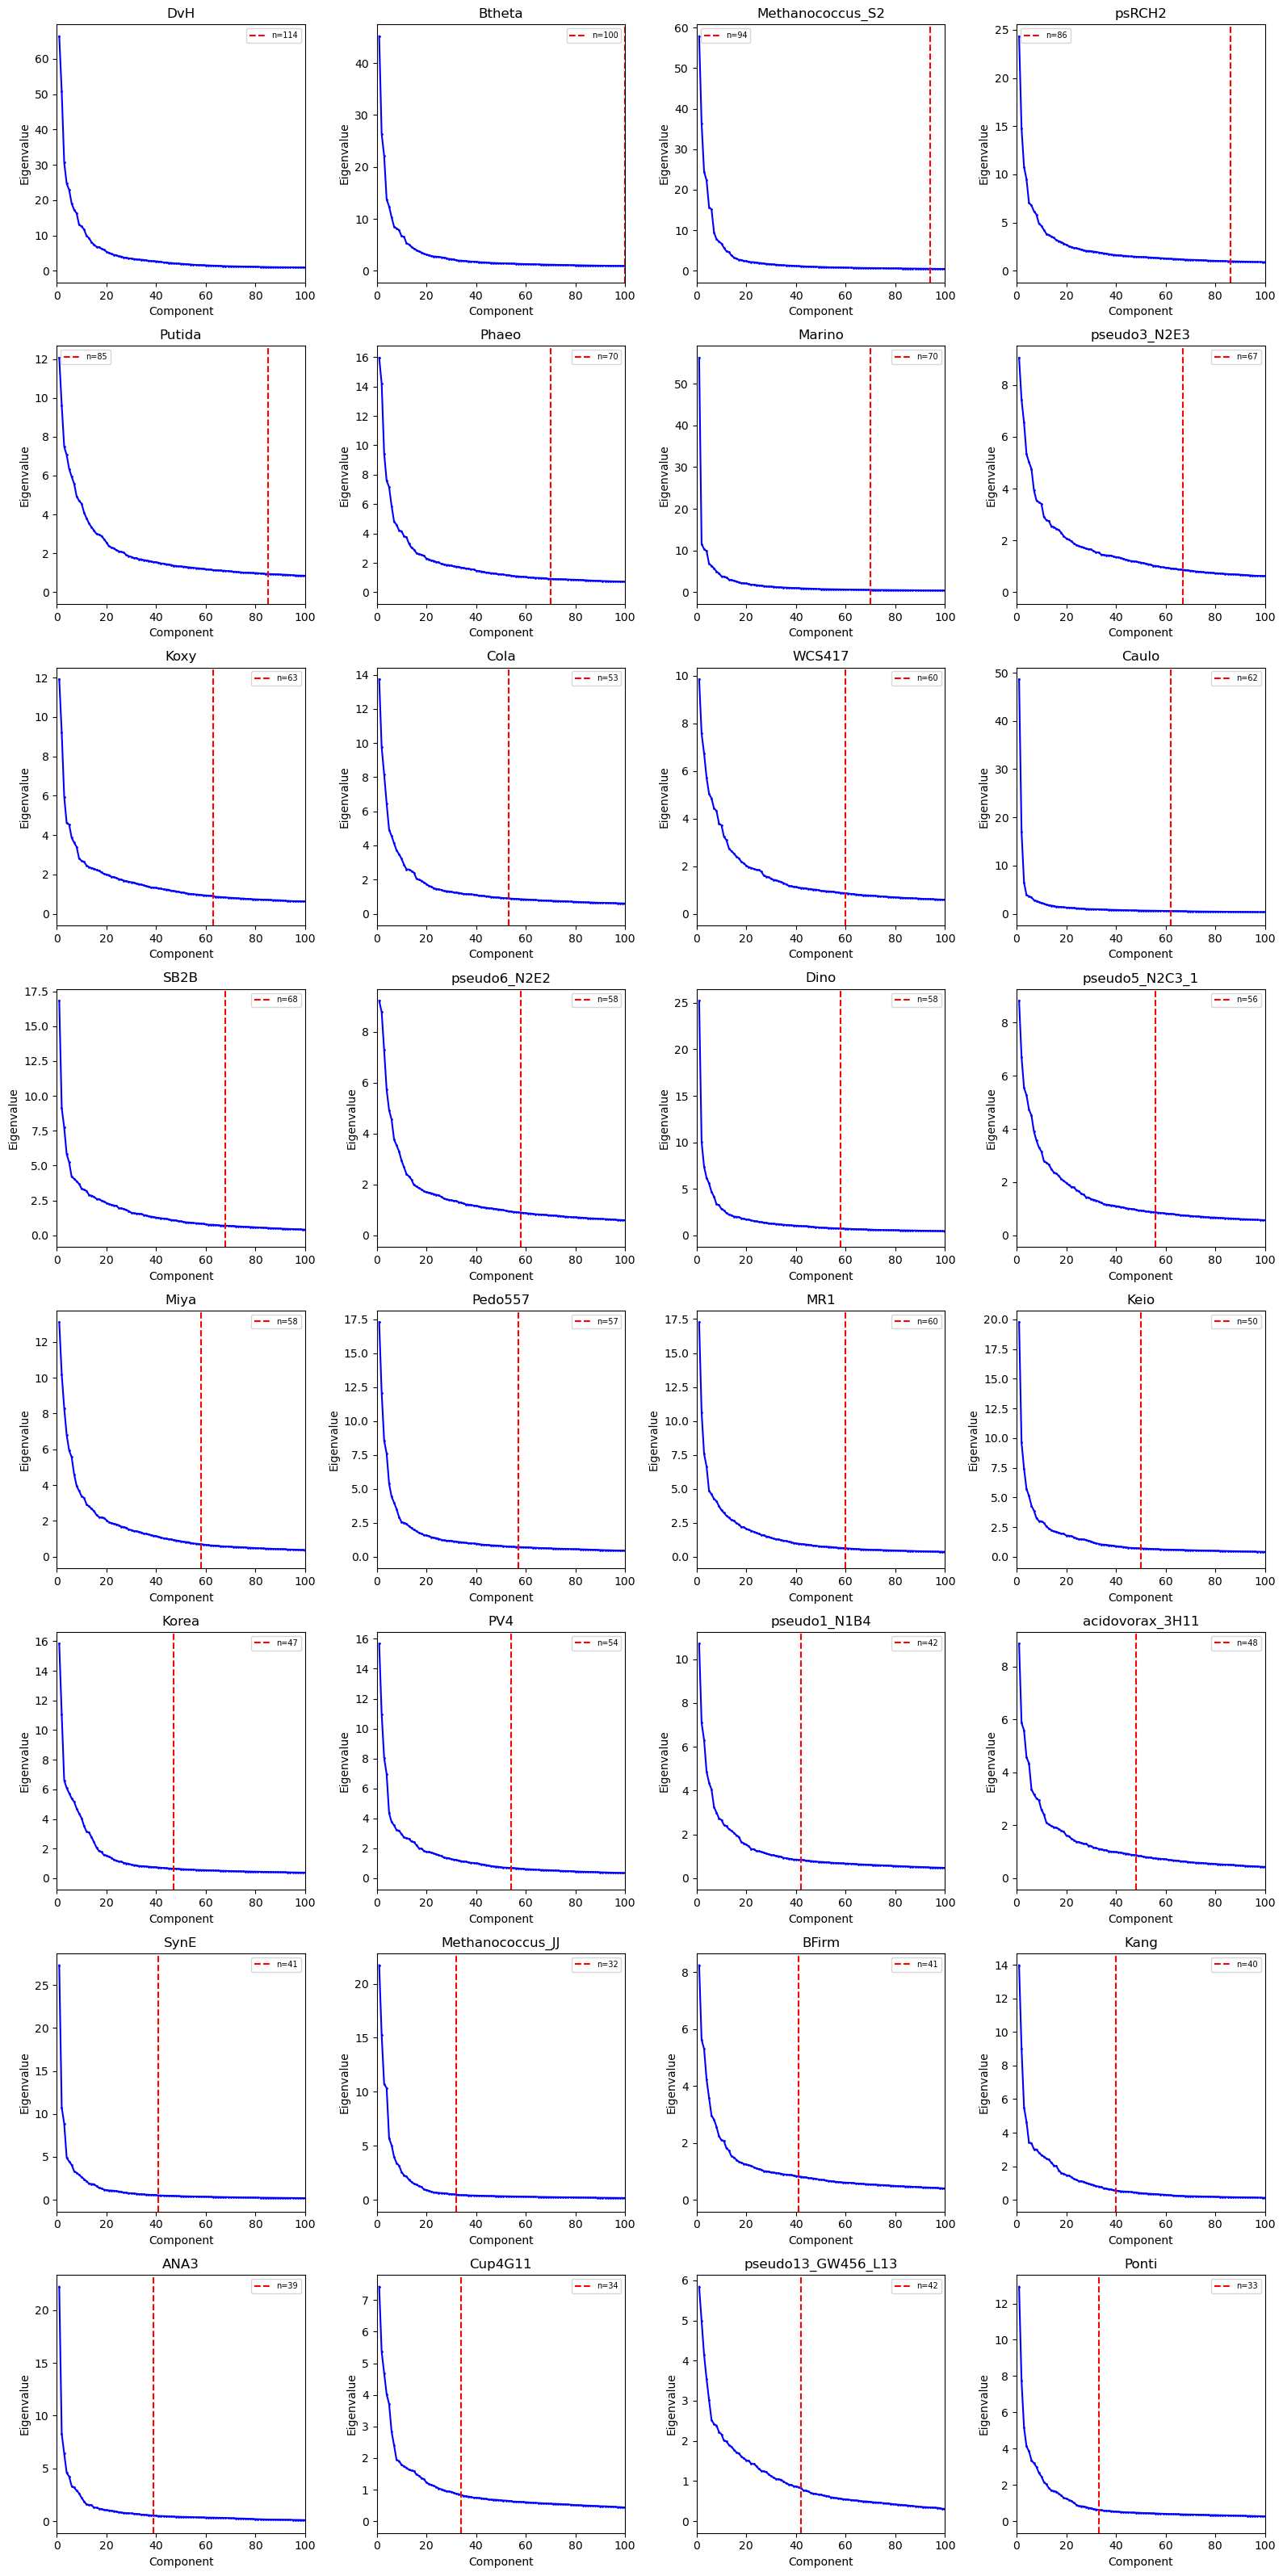

In [3]:
import matplotlib.pyplot as plt

n_cols = 4
n_rows = (len(pilot_ids) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten()

n_components_selected = {}

for i, org_id in enumerate(pilot_ids):
    ax = axes[i]
    fit_matrix = pd.read_csv(MATRIX_DIR / f'{org_id}_fitness_matrix.csv', index_col=0)
    X = fit_matrix.values
    X_std, _, _ = standardize_matrix(X)
    
    n_comp, eigenvalues = select_n_components(X_std, method='marchenko_pastur')
    n_components_selected[org_id] = n_comp
    
    ax.plot(range(1, len(eigenvalues)+1), eigenvalues, 'b.-', markersize=2)
    ax.axvline(n_comp, color='r', linestyle='--', label=f'n={n_comp}')
    ax.set_xlabel('Component')
    ax.set_ylabel('Eigenvalue')
    ax.set_title(f'{org_id}')
    ax.legend(fontsize=7)
    ax.set_xlim(0, min(100, len(eigenvalues)))
    
    print(f"{org_id}: matrix {X.shape}, selected {n_comp} components")

# Hide unused subplots
for j in range(len(pilot_ids), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.savefig('../figures/pca_eigenvalues.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Robust ICA

In [4]:
N_RUNS = 30
MAX_COMP = 80      # cap; also limited to 40% of n_experiments
EPS = 0.15
MIN_SAMPLES = 15
MIN_WEIGHT = 0.3   # absolute |weight| threshold for membership
MAX_MEMBERS = 50   # max genes per module

for org_id in pilot_ids:
    profile_file = MODULE_DIR / f'{org_id}_module_profiles.csv'
    weights_file = MODULE_DIR / f'{org_id}_gene_weights.csv'
    member_file = MODULE_DIR / f'{org_id}_gene_membership.csv'
    params_file = MODULE_DIR / f'{org_id}_ica_params.json'
    
    if profile_file.exists() and profile_file.stat().st_size > 0:
        print(f"CACHED: {org_id}")
        continue
    
    print(f"\n{'='*60}")
    print(f"Processing {org_id}")
    print(f"{'='*60}")
    
    # Load and standardize
    fit_matrix = pd.read_csv(MATRIX_DIR / f'{org_id}_fitness_matrix.csv', index_col=0)
    X = fit_matrix.values
    n_genes, n_exps = X.shape
    X_std, means, stds = standardize_matrix(X)
    
    # Select components: min(MP threshold, MAX_COMP, 40% of experiments)
    n_comp_mp, eigenvalues = select_n_components(X_std, method='marchenko_pastur')
    n_comp = min(n_comp_mp, MAX_COMP, int(n_exps * 0.4))
    n_components_selected[org_id] = n_comp
    
    print(f"Matrix: {n_genes} genes × {n_exps} experiments")
    print(f"Components: {n_comp} (MP={n_comp_mp}, cap={MAX_COMP})")
    print(f"Running {N_RUNS} ICA iterations...")
    
    # Run robust ICA
    modules, labels, all_components, metadata = robust_ica(
        X_std, n_comp, n_runs=N_RUNS, eps=EPS, min_samples=MIN_SAMPLES,
        max_iter=500, tol=1e-3
    )
    
    print(f"  Converged: {metadata['n_converged']}/{N_RUNS}")
    print(f"  Stable modules: {metadata['n_stable_modules']}")
    print(f"  Noise components: {metadata['n_noise_components']}")
    
    if metadata['n_stable_modules'] == 0:
        print(f"  WARNING: No stable modules found for {org_id}.")
        continue
    
    # Compute gene weights and threshold membership
    weights = compute_gene_weights(X_std, modules)
    membership, thresholds = threshold_membership(weights,
                                                   min_weight=MIN_WEIGHT,
                                                   max_members=MAX_MEMBERS)
    
    # Drop modules with 0 members
    n_members_per_module = membership.sum(axis=0)
    has_members = n_members_per_module > 0
    modules = modules[has_members]
    weights = weights[:, has_members]
    membership = membership[:, has_members]
    n_members_per_module = n_members_per_module[has_members]
    thresholds = thresholds[has_members]
    
    print(f"  Modules with members: {len(modules)}")
    print(f"  Members per module: min={n_members_per_module.min()}, "
          f"median={np.median(n_members_per_module):.0f}, "
          f"max={n_members_per_module.max()}")
    
    # Save
    module_names = [f'M{i:03d}' for i in range(len(modules))]
    pd.DataFrame(modules, index=module_names, columns=fit_matrix.columns).to_csv(profile_file)
    pd.DataFrame(weights, index=fit_matrix.index, columns=module_names).to_csv(weights_file)
    pd.DataFrame(membership, index=fit_matrix.index, columns=module_names).to_csv(member_file)
    
    params = {
        'orgId': org_id,
        'n_genes': int(n_genes),
        'n_experiments': int(n_exps),
        'n_components_mp': n_comp_mp,
        'n_components_used': n_comp,
        'n_runs': N_RUNS,
        'eps': EPS,
        'min_samples': MIN_SAMPLES,
        'min_weight': MIN_WEIGHT,
        'max_members': MAX_MEMBERS,
        'n_stable_modules': int(metadata['n_stable_modules']),
        'n_modules_with_members': int(len(modules)),
        'n_converged': int(metadata['n_converged']),
        'members_per_module': n_members_per_module.tolist(),
        'thresholds': thresholds.tolist()
    }
    with open(params_file, 'w') as f:
        json.dump(params, f, indent=2)
    
    print(f"  Saved to {MODULE_DIR}/")

CACHED: DvH
CACHED: Btheta
CACHED: Methanococcus_S2
CACHED: psRCH2
CACHED: Putida
CACHED: Phaeo
CACHED: Marino
CACHED: pseudo3_N2E3
CACHED: Koxy
CACHED: Cola
CACHED: WCS417
CACHED: Caulo
CACHED: SB2B
CACHED: pseudo6_N2E2
CACHED: Dino
CACHED: pseudo5_N2C3_1
CACHED: Miya
CACHED: Pedo557
CACHED: MR1
CACHED: Keio
CACHED: Korea
CACHED: PV4
CACHED: pseudo1_N1B4
CACHED: acidovorax_3H11
CACHED: SynE
CACHED: Methanococcus_JJ
CACHED: BFirm
CACHED: Kang
CACHED: ANA3
CACHED: Cup4G11
CACHED: pseudo13_GW456_L13
CACHED: Ponti


## 3. Module Quality Summary

In [5]:
# Summary across all organisms
all_params = []
for org_id in pilot_ids:
    params_file = MODULE_DIR / f'{org_id}_ica_params.json'
    if params_file.exists():
        with open(params_file) as f:
            all_params.append(json.load(f))

params_df = pd.DataFrame(all_params)
print("ICA Module Summary:")
print(params_df[['orgId', 'n_genes', 'n_experiments', 'n_components_used',
                  'n_stable_modules', 'n_modules_with_members', 'n_converged']].to_string(index=False))

print(f"\nTotal stable modules: {params_df['n_stable_modules'].sum()}")
print(f"Total modules with members: {params_df['n_modules_with_members'].sum()}")
print(f"All runs converged: {(params_df['n_converged'] == params_df['n_runs']).all()}")

ICA Module Summary:
             orgId  n_genes  n_experiments  n_components_used  n_stable_modules  n_modules_with_members  n_converged
               DvH     2741            757                 80                52                      52           50
            Btheta     4055            519                 80                36                      36           50
  Methanococcus_S2     1244            371                 80                27                      27           50
            psRCH2     3349            350                 80                41                      41           50
            Putida     4778            300                 80                38                      38           50
             Phaeo     3099            274                 70                37                      37           50
            Marino     3650            255                 70                39                      39           50
      pseudo3_N2E3     5028            211  

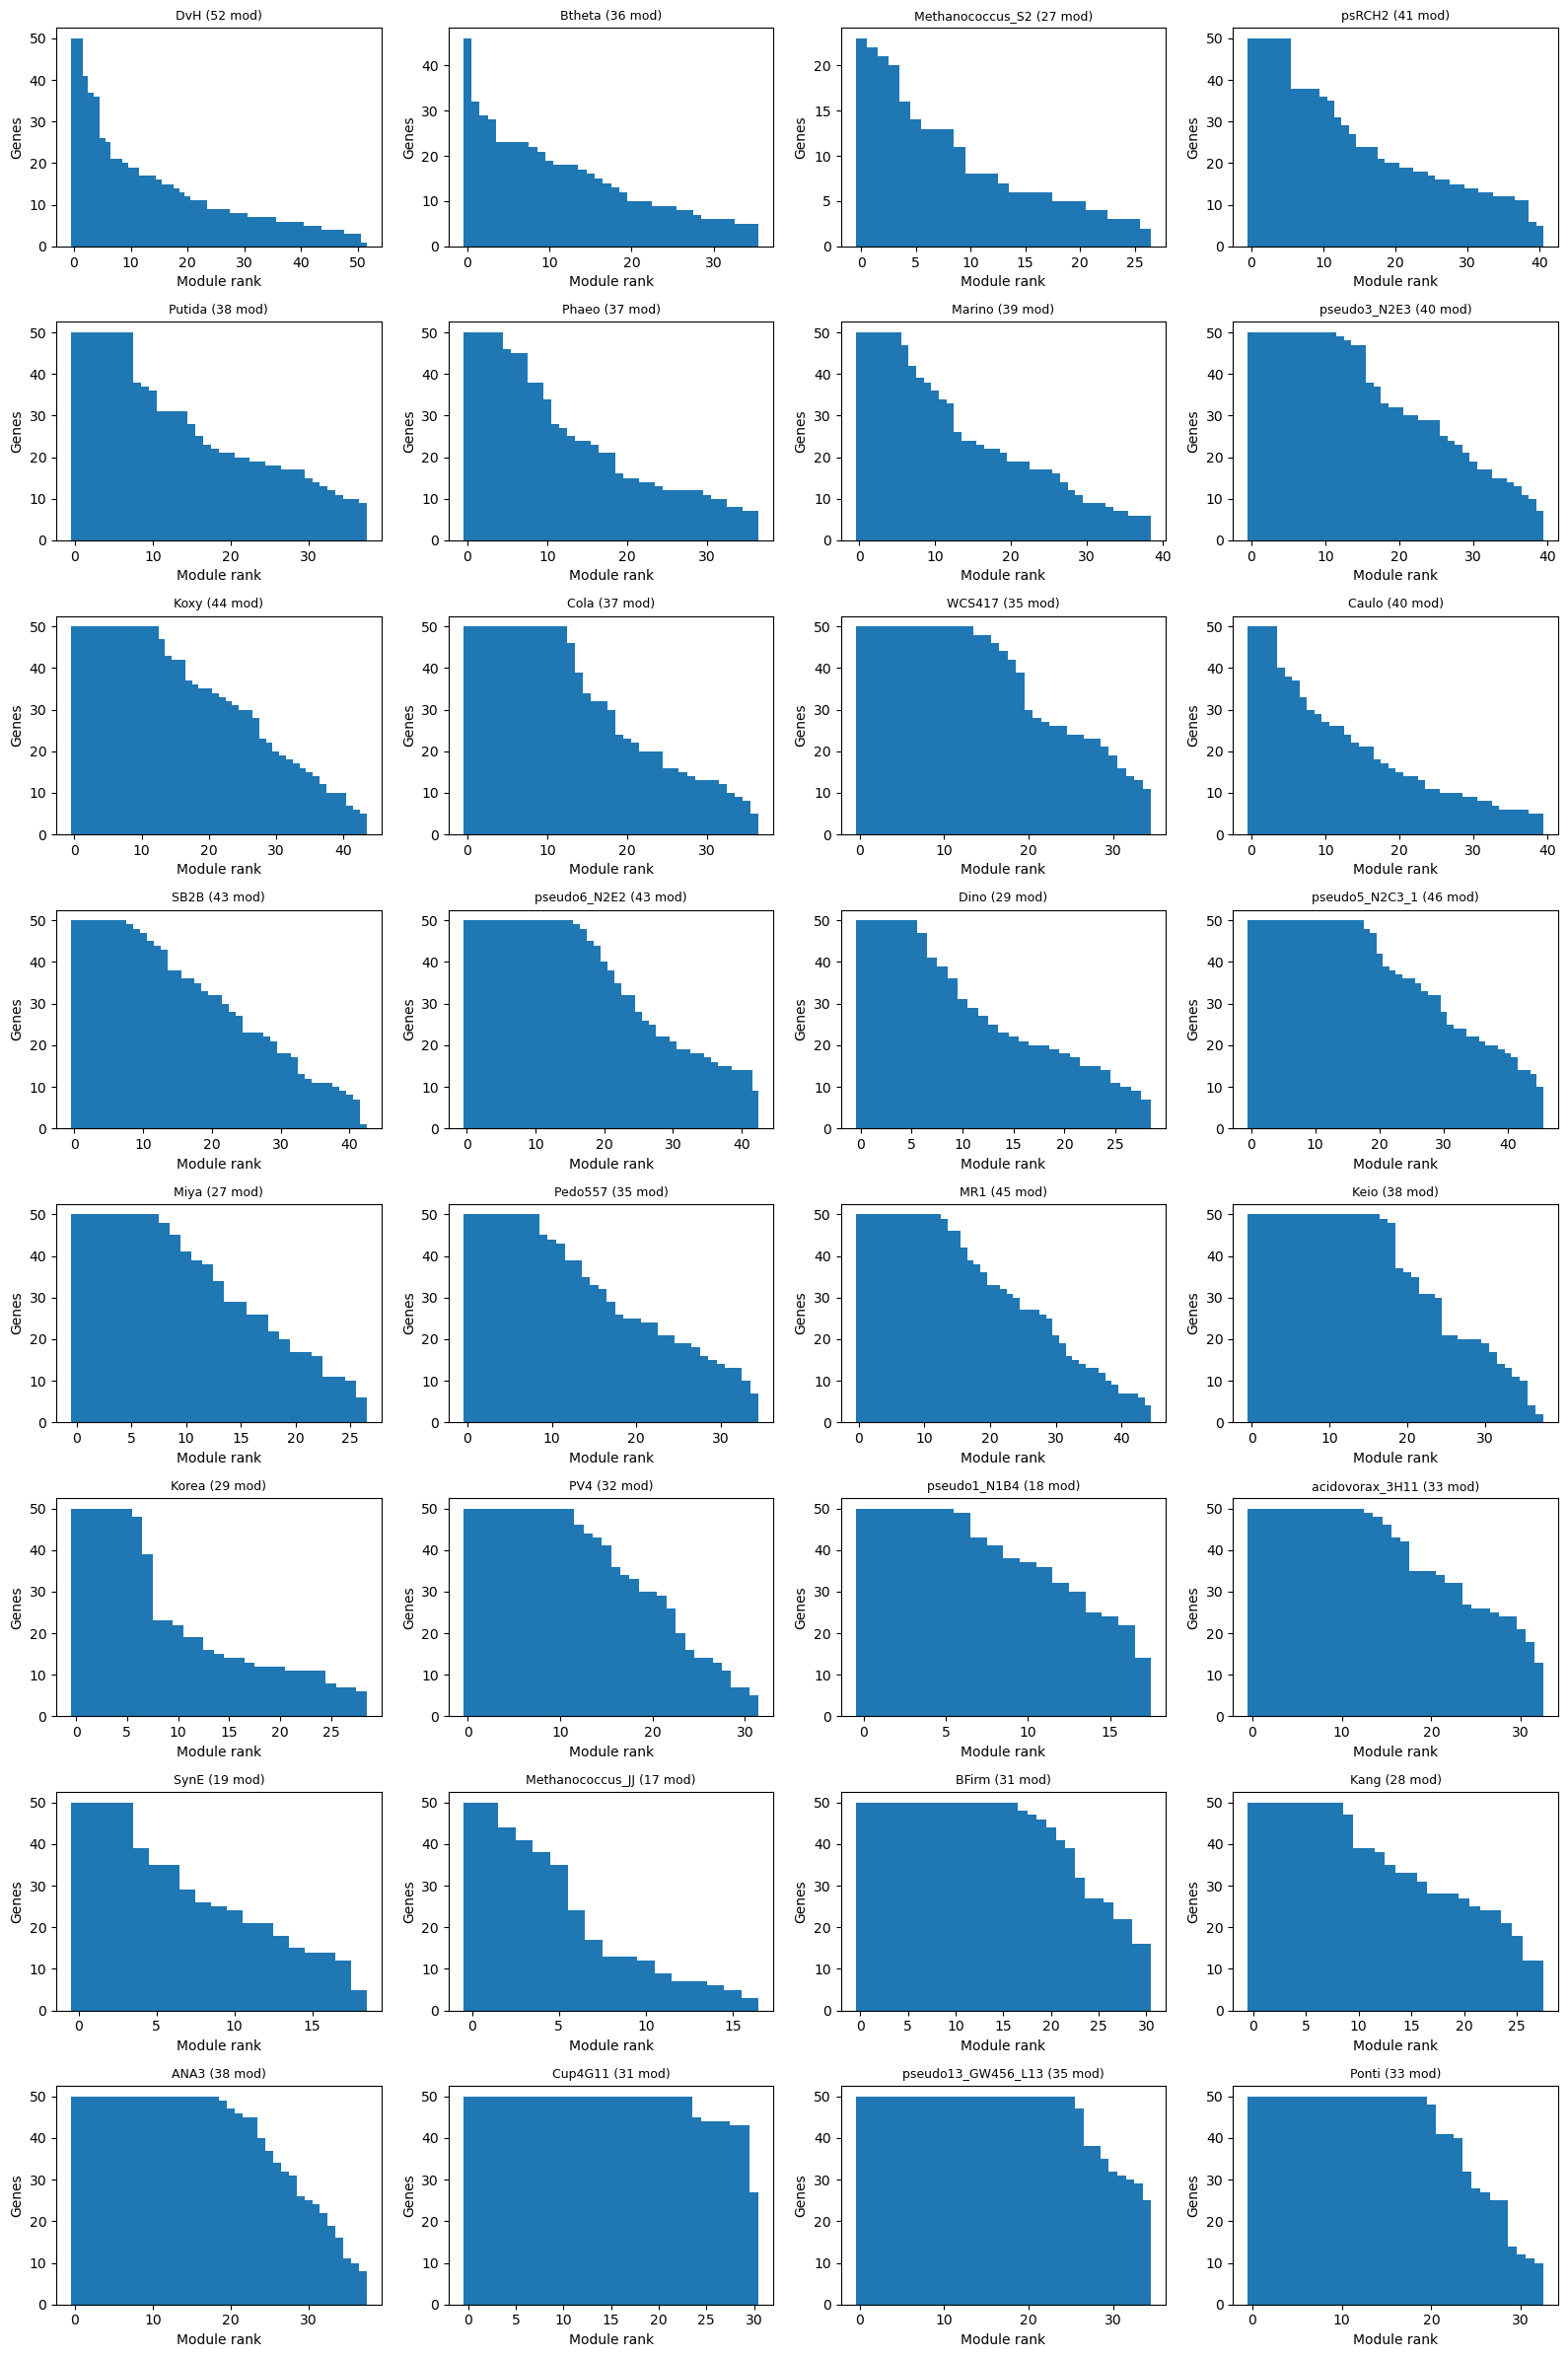

In [6]:
# Visualize module size distributions
n_cols = 4
n_rows = (len(pilot_ids) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
axes = axes.flatten()

for i, org_id in enumerate(pilot_ids):
    ax = axes[i]
    member_file = MODULE_DIR / f'{org_id}_gene_membership.csv'
    if not member_file.exists():
        continue
    membership = pd.read_csv(member_file, index_col=0)
    module_sizes = membership.sum(axis=0)
    ax.bar(range(len(module_sizes)), sorted(module_sizes, reverse=True), width=1.0)
    ax.set_xlabel('Module rank')
    ax.set_ylabel('Genes')
    ax.set_title(f'{org_id} ({len(module_sizes)} mod)', fontsize=9)

for j in range(len(pilot_ids), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.savefig('../figures/module_size_distribution.png', dpi=150, bbox_inches='tight')
plt.show()